<a href="https://colab.research.google.com/github/tpetric7/tpetric7.github.io/blob/main/Romane_suffixe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
knitr::opts_chunk$set(echo = TRUE)



# Install

In [ ]:
install.packages(c("tidytext", "SnowballC", "rmarkdown", "scales", "udpipe", "vecsets"))

In [ ]:
# devtools::install_github("quanteda/readtext")

# 0. Packages



In [ ]:
library(tidyverse)
library(tidytext)
library(SnowballC)
# library(readtext)
library(rmarkdown)
library(scales)
library(udpipe)
library(vecsets)


# 1. Dateien einlesen



In [ ]:
github = "https://raw.githubusercontent.com/tpetric7/tpetric7.github.io/main/data/books/"
# novels_txt = readtext(paste0(github, "*.txt"), docvarsfrom = "filenames", encoding = "UTF-8") %>% 
#  rename(title = docvar1)
# novels_txt
# novels = as.data.frame(novels_txt)


In [ ]:
github = "https://raw.githubusercontent.com/tpetric7/tpetric7.github.io/main/data/books/"
prozess = read_lines(paste0(github, "prozess.txt"))
tom = read_lines(paste0(github, "tom.txt"))

Wir wandeln die Datei in eine Tabelle um.



In [ ]:
prozess = as_tibble(prozess) %>% rename(text = value) %>% mutate(doc_id = "prozess")
tom = as_tibble(tom) %>% rename(text = value) %>% mutate(doc_id = "tom")
novels = rbind(prozess, tom)

In [ ]:
str(novels)

tibble [2 × 2] (S3: tbl_df/tbl/data.frame)
 $ text  : chr [1:2] "Der Prozess by Franz Kafka Aligned by : bilingual-texts.com ( fully reviewed )   Der Prozess      Franz Kafka  "| __truncated__ "Tom Sawyer by Mark Twain Aligned by : András Farkas ( autoalignment )   Source : Project Gutenberg      Die Abe"| __truncated__
 $ doc_id: chr [1:2] "prozess" "tom"


# 2. Lemmatisierung

Unser Ziel ist die Extrahierung von Wortbildungsmorphemen. Daher führen wir mit dem Program *udpipe* zuerst eine Analyse der Wortformen durch, die auch eine Lemmatisierung der Wortformen einschließt. Durch die Lemmatisierung können wir auf die Grundformen von Wörtern zurückgreifen und Flexionsmorpheme ausschließen.


In [ ]:
library(udpipe)
model = udpipe_download_model(language = "german")
demodel = udpipe_load_model(model$file_model)


Die Annotation der Wortformen kann mehrere Minuten dauern, falls es sich um längere Texte handelt.



In [ ]:
# x = udpipe_annotate(demodel, novels_txt$text, trace = TRUE)
x = udpipe_annotate(demodel, novels$text, trace = TRUE)
x = as.data.frame(x)


2021-08-06 09:11:12 Annotating text fragment 1/2
2021-08-06 09:13:57 Annotating text fragment 2/2


Wir filtern Interpunktionszeichen heraus, die für unser Ziel nicht relevant sind. Die Spalte "upos" enthält die dafür relevante Kategorie ("PUNCT").

In einem weiteren Schritt fügen wir mit *mutate* eine neue Spalte ("word") hinzu, welche die tokens der Texte enthält, aber kleingeschrieben gewerden sollen, was mit *tolower()* erreicht werden kann.


In [ ]:
udpipe = x %>% 
  filter(upos != "PUNCT") %>% 
  mutate(word = tolower(token))


Für die Entfernung von Ziffern und Symbolen aus der Tabelle verwenden wir einen regulären Ausdruck (regex). Außerdem sollen alle Lemmas mit Kleinbuchstaben beginnen.



In [ ]:
novels_words = udpipe %>% 
  filter(str_detect(lemma, "[:alpha:]")) %>% # keine Ziffern oder Interpunktionszeichen oder Symbole
  mutate(lemma = tolower(lemma))


Da wir vor allem an Wörtern interessiert sind, die aus mehr als einem Morphem bestehen, filtern wir u.a. Funktionswörter heraus, und zwar mit der Funktion *anti_join()* und einer Stoppwortliste aus dem Programm *stopwords*. 

Da die Stoppwortliste im Format einer Liste vorliegt, müssen wir sie in eine Tabelle umwandeln, und zwar mit der Funktion *as_tibble()*. Der Name der Tabellenspalte muss mit dem Namen der entsprechende Spalte in "novels_words" (also: "word") übereinstimmen, damit wir die beiden Tabellen entsprechend vereinen können. Den Namen von Tabellenspalten verändern wir mit *rename()*.

Außerdem wollen wir gleichzeitig auch einige Wörter herausfiltern, die nicht zu den Romantexten gehören: englische Wörter, die Namen der Autoren, eventuell noch nicht entfernte Ziffern, Interpunktionszeichen und Symbole. Zur Vereinigung der Wortformen in einen Vektor bzw. Tabellenspalte verwenden wir die concatenate-Funktion *c()*.

In einem weiteren Schritt sollen die Kategorien der "doc_id" bessere Namen erhalten: die allgemeineren Namen "doc1" und "doc2" ersetzen wir mit den eindeutigeren Namen "prozess" und "tom".


In [ ]:
install.packages("stopwords")

In [ ]:
install.packages("kableExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘webshot’




In [ ]:
library(kableExtra)
stoplist_de = c(stopwords::stopwords(language = "german"), "franz","kafka","mark","twain",
                "by","aligned","Aligned","","bilingual-texts.com","fully","reviewed") %>% 
  as_tibble() %>% 
  rename(word = value)

novels_words = novels_words %>% 
  mutate(doc_id = str_replace(doc_id, "doc1", "prozess"),
         doc_id = str_replace(doc_id, "doc2", "tom")) %>% 
  anti_join(stoplist_de, novels_words, by = "word") # möglichst keine Funktionswörter
head(novels_words, 10) %>% paged_table()
tail(novels_words, 10) %>% paged_table()


,doc_id,paragraph_id,sentence_id,sentence,token_id,token,lemma,upos,xpos,feats,head_token_id,dep_rel,deps,misc,word
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,prozess,1,1,"Der Prozess by Franz Kafka Aligned by : bilingual-texts.com ( fully reviewed ) Der Prozess Franz Kafka 1 Verhaftung , Gespräch mit Frau Grubach , dann Fräulein Brüstner Jemand mußte Josef K. verleumdet haben , denn ohne daß er etwas Böses getan hätte , wurde er eines Morgens verhaftet . Die Köchin der Frau Grubach , seiner Zimmervermieterin , die ihm jeden Tag gegen acht Uhr früh das Frühstück brachte , kam diesmal nicht . Das war noch niemals geschehen . K. wartete noch ein Weilchen , sah von seinem Kopfkissen aus die alte Frau , die ihm gegenüber wohnte und die ihn mit einer an ihr ganz ungewöhnlichen Neugierde beobachtete , dann aber , gleichzeitig befremdet und hungrig , läutete er . Sofort klopfte es und ein Mann , den er in dieser Wohnung noch niemals gesehen hatte , trat ein . Er war schlank und doch fest gebaut , er trug ein anliegendes schwarzes Kleid , das , ähnlich den Reiseanzügen , mit verschiedenen Falten , Taschen , Schnallen , Knöpfen und einem Gürtel versehen war und infolgedessen , ohne daß man sich darüber klar wurde , wozu es dienen sollte , besonders praktisch erschien . » Wer sind Sie ? « fragte K. und saß gleich halb aufrecht im Bett . Der Mann aber ging über die Frage hinweg , als müsse man seine Erscheinung hinnehmen , und sagte bloß seinerseits : » Sie haben geläutet ? « » Anna soll mir das Frühstück bringen « , sagte K. und versuchte , zunächst stillschweigend , durch Aufmerksamkeit und Überlegung festzustellen , wer der Mann eigentlich war . Aber dieser setzte sich nicht allzulange seinen Blicken aus , sondern wandte sich zur Tür , die er ein wenig öffnete , um jemandem , der offenbar knapp hinter der Tür stand , zu sagen : » Er will , daß Anna ihm das Frühstück bringt . « Ein kleines Gelächter im Nebenzimmer folgte , es war nach dem Klang nicht sicher , ob nicht mehrere Personen daran beteiligt waren . Obwohl der fremde Mann dadurch nichts erfahren haben konnte , was er nicht schon früher gewußt hätte , sagte er nun doch zu K. im Tone einer Meldung : » Es ist unmöglich . « » Das wäre neu « , sagte K. , sprang aus dem Bett und zog rasch seine Hosen an . » Ich will doch sehen ,",2,Prozess,prozeß,NOUN,NN,Case=Nom|Gender=Masc|Number=Sing,72,nsubj,NA,NA,prozess
2,prozess,1,1,"Der Prozess by Franz Kafka Aligned by : bilingual-texts.com ( fully reviewed ) Der Prozess Franz Kafka 1 Verhaftung , Gespräch mit Frau Grubach , dann Fräulein Brüstner Jemand mußte Josef K. verleumdet haben , denn ohne daß er etwas Böses getan hätte , wurde er eines Morgens verhaftet . Die Köchin der Frau Grubach , seiner Zimmervermieterin , die ihm jeden Tag gegen acht Uhr früh das Frühstück brachte , kam diesmal nicht . Das war noch niemals geschehen . K. wartete noch ein Weilchen , sah von seinem Kopfkissen aus die alte Frau , die ihm gegenüber wohnte und die ihn mit einer an ihr ganz ungewöhnlichen Neugierde beobachtete , dann aber , gleichzeitig befremdet und hungrig , läutete er . Sofort klopfte es und ein Mann , den er in dieser Wohnung noch niemals gesehen hatte , trat ein . Er war schlank und doch fest gebaut , er trug ein anliegendes schwarzes Kleid , das , ähnlich den Reiseanzügen , mit verschiedenen Falten , Taschen , Schnallen , Knöpfen und einem Gürtel versehen war und infolgedessen , ohne daß man sich darüber klar wurde , wozu es dienen sollte , besonders praktisch erschien . » Wer sind Sie ? « fragte K. und saß gleich halb aufrecht im Bett . Der Mann aber ging über die Frage hinweg , als müsse man seine Erscheinung hinnehmen , und sagte bloß seinerseits : » Sie haben geläutet ? « » Anna soll mir das Frühstück bringen « , sagte K. und versuchte , zunächst stillschweigend , durch Aufmerksamkeit und Überlegung festzustellen , wer der Mann eigentlich war . Aber dieser setzte sich nicht allzulange sein

,doc_id,paragraph_id,sentence_id,sentence,token_id,token,lemma,upos,xpos,feats,head_token_id,dep_rel,deps,misc,word
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
67723,tom,1,293,"ohne die eines Mannes zu werden . Wenn jemand eine Erzählung über erwachsene Leute schreibt , weiß er genau , wo er aufzuhören hat -- bei der Heirat ; schreibt er aber über ein unreifes Kind , so muß er aufhören , wo er's für passend hält . Die meisten der in diesem Buch vorkommenden Personen leben noch , sind glücklich und mehren sich . Vielleicht erscheint es eines Tages als angebracht , die Geschichte der Jugend wieder aufzunehmen und zu sehen , was für Männer und Frauen aus ihnen geworden sind ; darum wird's am besten sein , von ihrem jetzigen Leben hier nichts mehr zu verraten .",86,Männer,mann,NOUN,NN,Case=Acc|Gender=Masc|Number=Plur,91,obl,NA,NA,männer
67724,tom,1,293,"ohne die eines Mannes zu werden . Wenn jemand eine Erzählung über erwachsene Leute schreibt , weiß er genau , wo er aufzuhören hat -- bei der Heirat ; schreibt er aber über ein unreifes Kind , so muß er aufhören , wo er's für passend hält . Die meisten der in diesem Buch vorkommenden Personen leben noch , sind glücklich und mehren sich . Vielleicht erscheint es eines Tages als angebracht , die Geschichte der Jugend wieder aufzunehmen und zu sehen , was für Männer und Frauen aus ihnen geworden sind ; darum wird's am besten sein , von ihrem jetzigen Leben hier nichts mehr zu verraten .",88,Frauen,frau,NOUN,NN,Case=Acc|Gender=Fem|Number=Plur,86,conj,NA,NA,frauen
67725,tom,1,293,"ohne die eines Mannes zu werden . Wenn jemand eine Erzählung über erwachsene Leute schreibt , weiß er genau , wo er aufzuhören hat -- bei der Heirat ; schreibt er aber über ein unreifes Kind , so muß er aufhören , wo er's für passend hält . Die meisten der in diesem Buch vorkommenden Personen leben noch , sind glücklich und mehren sich . Vielleicht erscheint es eines Tages als angebracht , die Geschichte der Jugend wieder aufzunehmen und zu sehen , was für Männer und Frauen aus ihnen geworden sind ; darum wird's am besten sein , von ihrem jetzigen Leben hier nichts mehr zu verraten .",91,geworden,werden,VERB,ADJA,Case=Acc|Gender=Fem|Number=Sing,82,acl,NA,NA,geworden
67726,tom,1,293,"ohne die eines Mannes zu werden . Wenn jemand eine Erzählung über erwachsene Leute schreibt , weiß er genau , wo er aufzuhören hat -- bei der Heirat ; schreibt er aber über ein unreifes Kind , so muß er aufhören , wo er's für passend hält . Die meisten der in diesem Buch vorkommenden Personen leben noch , sind glücklich und mehren sich . Vielleicht erscheint es eines Tages als angebracht , die Geschichte der Jugend wieder aufzunehmen und zu sehen , was für Männer und Frauen aus ihnen geworden sind ; darum wird's am besten sein , von ihrem jetzigen Leben hier nichts mehr zu verraten .",94,darum,darum,ADV,PAV,NA,95,advmod,NA,NA,darum
67727,tom,1,293,"ohne die eines Mannes zu werden . Wenn jemand eine Erzählung über erwachsene Leute schreibt , weiß er genau , wo er aufzuhören hat -- bei der Heirat ; schreibt er aber über ein unreifes Kind , so muß er aufhören , wo er's für passend hält . Die meisten der in diesem Buch vorkommenden Personen leben noch , sind glücklich und mehren sich . Vielleicht erscheint es eines Tages als angebracht , die Geschichte der Jugend wieder aufzunehmen und zu sehen , was für Männer und Frauen aus ihnen geworden sind ; darum wird's am besten sein , von ihrem jetzigen Leben hier nichts mehr zu verraten .",95,wird's,wird's,X,PPER,Foreign=Yes,98,nsubj,NA,NA,wird's
67728,tom,1,293,"ohne die eines Mannes zu werden . Wenn jemand eine Erzählung über erwachsene Leute schreibt , weiß er genau , wo er aufzuhören hat -- bei der Heirat ; schreibt er aber über ein unreifes Kind , so muß er aufhören , wo er's für passend hält . Die meisten der in diesem Buch vorkommenden Personen leben noch , sind glücklich und mehren sich . Vielleicht erscheint es eines Tages als angebracht

# 3. Stemming

Beim Stemming werden die Stämme von Wortformen extrahiert. In flexionsarmen Sprachen (z.B. Englisch) sind die Ergebnisse gewöhnlich nützlicher als in morphologisch reichen Sprachen (z.B. Deutsch, Slowenisch).

Hier verwenden wir die Stemming-Funktion *wordStem()* des Programms *SnowballC*, um potentielle Suffixe und Suffixoide komplexer Wörter zu extrahieren. Das Ziel ist eine morphologische Vergleichsanalyse, und zwar von Wortbildungsmorphemen in den Romaen.

Mit *mutate()* und der *wordStem()*-Funktion fügen wir der Tabelle eine weitere Spalte hinzu, der wir den Namen "stamm" geben. 


In [ ]:
novels_words = novels_words %>% 
  mutate(stamm = wordStem(lemma, language = "de"))
head(novels_words) %>% paged_table()


,doc_id,paragraph_id,sentence_id,sentence,token_id,token,lemma,upos,xpos,feats,head_token_id,dep_rel,deps,misc,word,stamm
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,prozess,1,1,"Der Prozess by Franz Kafka Aligned by : bilingual-texts.com ( fully reviewed ) Der Prozess Franz Kafka 1 Verhaftung , Gespräch mit Frau Grubach , dann Fräulein Brüstner Jemand mußte Josef K. verleumdet haben , denn ohne daß er etwas Böses getan hätte , wurde er eines Morgens verhaftet . Die Köchin der Frau Grubach , seiner Zimmervermieterin , die ihm jeden Tag gegen acht Uhr früh das Frühstück brachte , kam diesmal nicht . Das war noch niemals geschehen . K. wartete noch ein Weilchen , sah von seinem Kopfkissen aus die alte Frau , die ihm gegenüber wohnte und die ihn mit einer an ihr ganz ungewöhnlichen Neugierde beobachtete , dann aber , gleichzeitig befremdet und hungrig , läutete er . Sofort klopfte es und ein Mann , den er in dieser Wohnung noch niemals gesehen hatte , trat ein . Er war schlank und doch fest gebaut , er trug ein anliegendes schwarzes Kleid , das , ähnlich den Reiseanzügen , mit verschiedenen Falten , Taschen , Schnallen , Knöpfen und einem Gürtel versehen war und infolgedessen , ohne daß man sich darüber klar wurde , wozu es dienen sollte , besonders praktisch erschien . » Wer sind Sie ? « fragte K. und saß gleich halb aufrecht im Bett . Der Mann aber ging über die Frage hinweg , als müsse man seine Erscheinung hinnehmen , und sagte bloß seinerseits : » Sie haben geläutet ? « » Anna soll mir das Frühstück bringen « , sagte K. und versuchte , zunächst stillschweigend , durch Aufmerksamkeit und Überlegung festzustellen , wer der Mann eigentlich war . Aber dieser setzte sich nicht allzulange seinen Blicken aus , sondern wandte sich zur Tür , die er ein wenig öffnete , um jemandem , der offenbar knapp hinter der Tür stand , zu sagen : » Er will , daß Anna ihm das Frühstück bringt . « Ein kleines Gelächter im Nebenzimmer folgte , es war nach dem Klang nicht sicher , ob nicht mehrere Personen daran beteiligt waren . Obwohl der fremde Mann dadurch nichts erfahren haben konnte , was er nicht schon früher gewußt hätte , sagte er nun doch zu K. im Tone einer Meldung : » Es ist unmöglich . « » Das wäre neu « , sagte K. , sprang aus dem Bett und zog rasch seine Hosen an . » Ich will doch sehen ,",2,Prozess,prozeß,NOUN,NN,Case=Nom|Gender=Masc|Number=Sing,72,nsubj,NA,NA,prozess,prozess
2,prozess,1,1,"Der Prozess by Franz Kafka Aligned by : bilingual-texts.com ( fully reviewed ) Der Prozess Franz Kafka 1 Verhaftung , Gespräch mit Frau Grubach , dann Fräulein Brüstner Jemand mußte Josef K. verleumdet haben , denn ohne daß er etwas Böses getan hätte , wurde er eines Morgens verhaftet . Die Köchin der Frau Grubach , seiner Zimmervermieterin , die ihm jeden Tag gegen acht Uhr früh das Frühstück brachte , kam diesmal nicht . Das war noch niemals geschehen . K. wartete noch ein Weilchen , sah von seinem Kopfkissen aus die alte Frau , die ihm gegenüber wohnte und die ihn mit einer an ihr ganz ungewöhnlichen Neugierde beobachtete , dann aber , gleichzeitig befremdet und hungrig , läutete er . Sofort klopfte es und ein Mann , den er in dieser Wohnung noch niemals gesehen hatte , trat ein . Er war schlank und doch fest gebaut , er trug ein anliegendes schwarzes Kleid , das , ähnlich den Reiseanzügen , mit verschiedenen Falten , Taschen , Schnallen , Knöpfen und einem Gürtel versehen war und infolgedessen , ohne daß man sich darüber klar wurde , wozu es dienen sollte , besonders praktisch erschien . » Wer sind Sie ? « fragte K. und saß gleich halb aufrecht im Bett . Der Mann aber ging über die Frage hinweg , als müsse man seine Erscheinung hinnehmen , und sagte bloß seinerseits : » Sie haben geläutet ? « » Anna soll mir das Frühstück bringen « , sagte K. und versuchte , zunächst stillschweigend , durch Aufmerksamkeit und Überlegung festzustellen , wer der Mann eigentlich war . Aber dieser setzte sich n

Nun stehen uns die Lemma- und Stammformen zur Verfügung. Der Unterschied zwischen den jeweiligen Formen sollte (meist) Wortbildungsmorpheme (Suffixe) ergeben.

Um Unterschiede zwischen den in den Spalten "lemma" und "stamm" gespeicherten Wortformen zu bestimmen, wollen wir ein spezielles Programm verwenden: *library(vectsets)*.

Dann folgen einige Korrekturen mit *str_remove()*, *str_remove_all()*, *str_replace()* und *str_replace_all()*, damit in der Spalte "diffs" möglichst nur Wortbildungssuffixe vorkommen.

Mit *str_remove()* beseitigen wir ein Zeichen einmal, mit *str_remove_all()* so oft, wie es in einer Tabellenspalte vorkommt.
Mit *str_replace()* wandeln wir ein Zeichen einmal in ein anderes um, mit *str_replace_all()* so oft, wie es in einer Tabellenspalte vorkommt.


In [ ]:
library(vecsets)
novels_full_words = novels_words %>% 
  mutate(diffs = as.character(mapply(vsetdiff, strsplit(lemma, split = ""),
                            strsplit(stamm, split = "")))) %>% 
  mutate(diffs = str_remove(diffs, "c\\("),
         diffs = str_remove(diffs, "\\)"),
         diffs = str_remove_all(diffs, '\\"'),
         diffs = str_remove_all(diffs, ", "), 
         diffs = str_replace(diffs, "character\\(0", ""),
         diffs = str_replace(diffs, "ß", ""),
         diffs = str_replace_all(diffs, "ä", ""),
         diffs = str_replace_all(diffs, "ö", ""),
         diffs = str_replace_all(diffs, "ü", ""))


Das Ergebnis ist nicht perfekt, aber für bestimmte Wortbildungssuffixe brauchbar.



In [ ]:
novels_full_words %>% 
  select(doc_id, lemma, stamm, diffs) %>% 
head(10) %>% paged_table()


,doc_id,lemma,stamm,diffs
,<chr>,<chr>,<chr>,<chr>
1,prozess,prozeß,prozess,
2,prozess,prozeß,prozess,
3,prozess,verhaftung,verhaft,ung
4,prozess,gespräch,gesprach,
5,prozess,frau,frau,
6,prozess,grubach,grubach,
7,prozess,fräulein,fraulein,
8,prozess,brüstner,brustn,er
9,prozess,jemand,jemand,


Wir speichern die Tabelle für spätere Analysen. Möglich sind verschiedene Formate, z.B. "rds"-Dateien, die man mit R/Rstudio öffnen kann, und "csv"-Dateien, die man mit beliebigen Programmen öffnen kann. 
Aber wir speichern die Tabelle hier nur als Excel-Datei ab, weil die Tabellenzeilen nicht zu lang sind.


In [ ]:
# write_rds(novels_full_words, "data/novels_full_words.rds")
# write_csv(novels_full_words, "data/novels_full_words.csv")
# writexl::write_xlsx(novels_full_words, "data/novels_full_words.xlsx")


# 4. Wortbildungsanalyse

Um am nächsten Tag nicht alle vorherigen Schritte noch einmal machen zu müssen, können wir an dieser Stelle die zuvor gespeicherte Tabelle öffnen.


In [ ]:
# novels_full_words = readxl::read_xlsx("data/novels_full_words.xlsx")



Wir beginnen unsere Wortbildungsanalyse mit dem Abzählen von verschiedenen Endungen, die von unserem Programm identifiziert wurden.

Wir wählen mit *select()* nur ein paar Tabellenspalten aus, damit wir die Übersicht behalten.
Die Ergebnisse sollen nach dem Romantitel gruppiert werden, was man mit *group_by()* bewerkstelligt.
Mit *filter()* werden leere Zeilen in der Tabellenspalte "diffs" herausgefiltert.
Dann zählen wir die verschiedenen Kategorien in der Tabellenspalte, und zwar mit *count()*.
Zuletzt verändern wir mit *pivot_wider()* das Tabellenformat, so dass die Romantitel als Spaltennamen erscheinen und die Endungen als Tabellenzeilen. Die Spalten "prozess" und "tom" enthalten nun die Häufigkeitswerte für die einzelnen Endungen.


In [ ]:
novels_full_words %>% 
  select(doc_id, lemma, stamm, diffs) %>%
  group_by(doc_id) %>% 
  filter(diffs != "") %>%
  count(diffs) %>% 
  pivot_wider(names_from = doc_id, values_from = n) %>% 
  paged_table()


diffs,prozess,tom
<chr>,<int>,<int>
e,2047,2587
em,108,36
en,10570,9914
end,157,184
ende,9,10
endem,1,NA
enden,12,8
ender,3,NA
ends,2,NA


Wir erweitern unsere Häufigkeitstabelle mit Prozentzahlen und geben ihr einen Namen ("novels_diffs").



In [ ]:
novels_diffs = novels_full_words %>% 
  select(doc_id, lemma, stamm, diffs) %>%
  group_by(doc_id) %>% 
  filter(diffs != "") %>%
  count(diffs) %>% 
  pivot_wider(names_from = doc_id, values_from = n) %>% 
  mutate(prozess_total = sum(prozess, na.rm = TRUE),
         tom_total = sum(tom, na.rm = TRUE)) %>% 
  mutate(prozess_pct = prozess/prozess_total,
         tom_pct = tom/tom_total,) %>% 
  select(-prozess_total, -tom_total)

head(novels_diffs) %>% paged_table()


diffs,prozess,tom,prozess_pct,tom_pct
<chr>,<int>,<int>,<dbl>,<dbl>
e,2047,2587,1.150646e-01,0.1541808213
em,108,36,6.070826e-03,0.0021455391
en,10570,9914,5.941540e-01,0.5908576196
end,157,184,8.825183e-03,0.0109660886
ende,9,10,5.059022e-04,0.0005959831
endem,1,NA,5.621135e-05,NA


Noch eine graphische Darstellung der Häufigkeitswerte, für die wir die Tabelle umformen, und zwar mit *pivot_longer()* und verkürzen (durch Filtervorgänge): wir wollen nur Endungen mit einer Häufigkeit von mehr als 0,5% (0.005) beibehalten. Mit *fct_lump()* kann man die Anzahl der Kategorien reduzieren (die Restkategorie heißt hier "Other"). Mit *fct_reorder()* sorgen wir dafür, dass die häufigeren Endungen im Diagramm oben erscheinen. Die Funktion *facet_wrap()* ermöglicht die getrennte Darstellung der Romane.



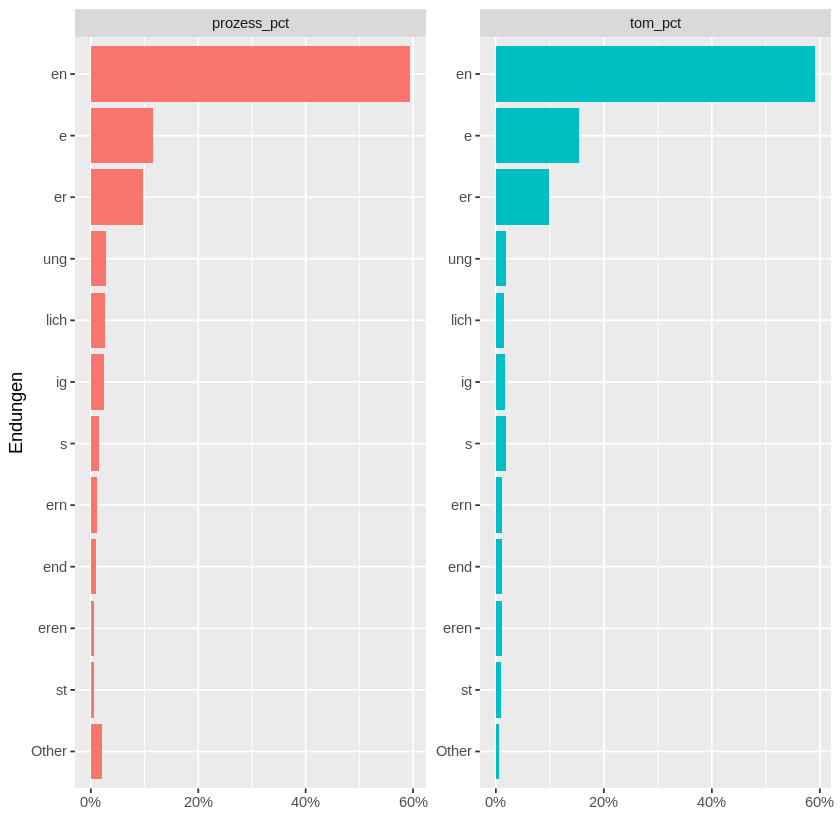

In [ ]:
library(scales)

novels_diffs %>% 
  pivot_longer(cols = prozess_pct:tom_pct, names_to = "title", values_to = "prozent") %>% 
  filter(!is.na(prozent)) %>% 
  filter(prozent > 0.005) %>% 
  mutate(diffs = fct_lump(diffs, 10)) %>% 
  mutate(diffs = fct_reorder(diffs, prozent)) %>% 
  ggplot(aes(prozent, diffs, fill = title)) +
  geom_col() +
  theme(legend.position = "none") +
  scale_x_continuous(labels = percent) +
  labs(x = "", y = "Endungen") +
  facet_wrap(~ title, scales = "free")


Vergleichen wir mal die Häufigkeit der Endung "-lich" in den Romanen! Da dieses Wortbildungssuffix mit adjektivischen Stämmen verknüpft wird, filtern die entsprechende Wortklasse heraus.



In [ ]:
(lich_tab = novels_full_words %>% 
  group_by(doc_id) %>% 
  filter(upos == "ADJ") %>% 
  count(diffs == "lich") %>%
  rename(lich = `diffs == "lich"`) %>% 
  filter(!is.na(lich)) %>% 
  pivot_wider(names_from = doc_id, values_from = n)
)


lich,prozess,tom
<lgl>,<int>,<int>
FALSE,4785,5204
TRUE,386,213


Ist der Unterschied zwischen den Romanen statistisch signifikant? Das überprüfen wir mit dem Chi-Quadrat-Test. Die erste Spalte enthält keine Zahlen, daher müssen wir sie beim Testen entfernen, und zwar mit *[, -1]*: alle Zeilen übernehmen, aber die este Tabellenspalte nicht.



In [ ]:
chisq.test(lich_tab[,-1])




	Pearson's Chi-squared test with Yates' continuity correction

data:  lich_tab[, -1]
X-squared = 61.198, df = 1, p-value = 5.161e-15


Der Chi-Quadrat-Test hat lediglich einen signifikanten Unterschied zwischen den beiden Stichproben "prozess" und "tom" bestätigt, sagt uns aber nicht, in welcher Stichprobe, das Suffix "-lich" verhältnismäßig häufiger vorkommt. Bei dieser Beurteilung helfen uns Prozentzahlen.



In [ ]:
lichtab2 = novels_full_words %>% 
  group_by(doc_id) %>% 
  filter(upos == "ADJ") %>% 
  count(diffs == "lich") %>% 
  rename(lich = `diffs == "lich"`) %>% 
  filter(!is.na(lich)) %>% 
  pivot_wider(names_from = doc_id, values_from = n) %>% 
  mutate(prozess_total = sum(prozess, na.rm = TRUE),
         tom_total = sum(tom, na.rm = TRUE)) %>% 
  mutate(prozess_pct = prozess/prozess_total,
         tom_pct = tom/tom_total,) %>% 
  select(-prozess_total, -tom_total)

lichtab2 %>% paged_table()


lich,prozess,tom,prozess_pct,tom_pct
<lgl>,<int>,<int>,<dbl>,<dbl>
FALSE,4785,5204,0.92535293,0.96067934
TRUE,386,213,0.07464707,0.03932066


Etwa 21,5% der als Adjektiv identifizierten Lemmas im Roman "prozess" enden mit dem Suffix "-lich", im Roman "tom sawyer" sind es etwa 15,2%. Der Unterschied ist auch in der graphischen Darstellung zu sehen.



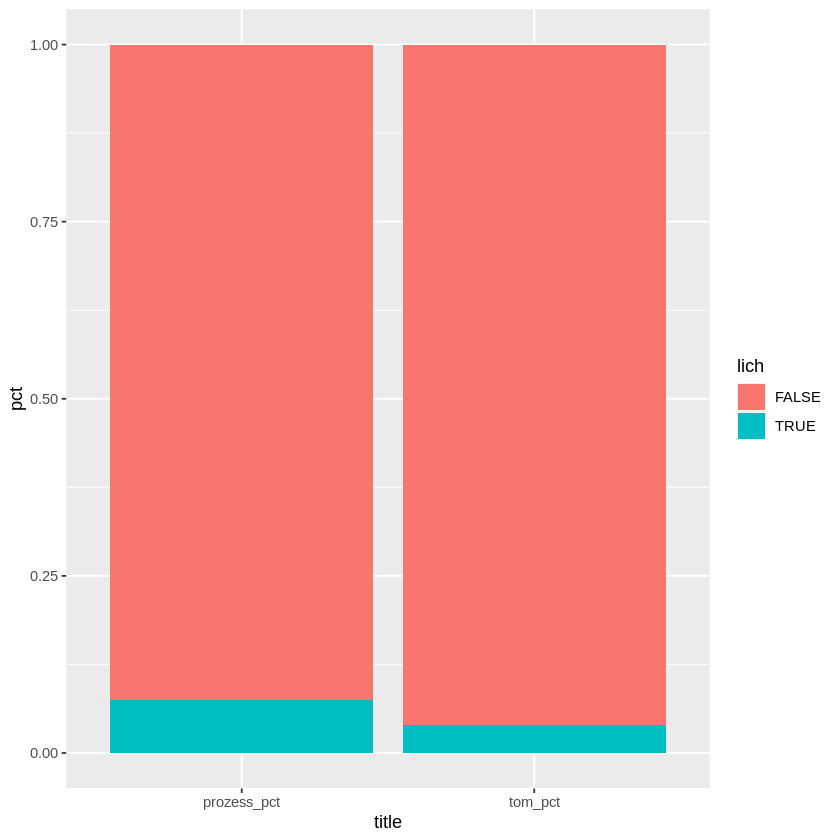

In [ ]:
lichtab2 %>% 
  pivot_longer(prozess_pct:tom_pct, names_to = "title", values_to = "pct") %>% 
  ggplot(aes(title, pct, fill = lich)) +
  geom_col()


Das Suffix "-lich" gehört zu den produktiven Wortbildungsmitteln im Deutschen. Warum sind im "prozess" mehr davon zu finden als im anderen Roman? Zur Klärung dieser Frage müssten wir zuerst mehr über die semantischen Eigenschaften und Verknüpfungsmöglichkeiten (oder -einschränkungen) mit verschiedenen Wortstämmen erfahren.



In [ ]:
novels_full_words %>% 
  select(doc_id, lemma, word, upos, diffs) %>%
  group_by(doc_id, lemma, word) %>% 
  filter(upos == "ADJ") %>% 
  filter(diffs == "lich") %>% 
  paged_table()


doc_id,lemma,word,upos,diffs
<chr>,<chr>,<chr>,<chr>,<chr>
prozess,ungewöhnlich,ungewöhnlichen,ADJ,lich
prozess,eigentlich,eigentlich,ADJ,lich
prozess,unmöglich,unmöglich,ADJ,lich
prozess,freundschaftlich,freundschaftlich,ADJ,lich
prozess,zuversichtlich,zuversichtlich,ADJ,lich
prozess,freundschaftlich,freundschaftlich,ADJ,lich
prozess,natürlich,natürlich,ADJ,lich
prozess,unähnlich,unähnlich,ADJ,lich
prozess,wahrscheinlich,wahrscheinlich,ADJ,lich


Vergleichen wir die Häufigkeit von mehreren adjektivischen Suffixen in unserem Romankorpus!



In [ ]:
novels_full_words %>% 
  select(doc_id, lemma, word, upos, diffs) %>% # Auswahl von hier relevanten Spalten
  group_by(doc_id, lemma, word) %>% # Gruppierung nach diesen Merkmalen (Spalten)
  filter(upos == "ADJ") %>% # Auswahl der Wortklasse
  filter(diffs == "lich" | 
           diffs == "erlich" | 
           diffs == "isch" | 
           diffs == "ig") %>% # Suffixauswahl
  paged_table()


doc_id,lemma,word,upos,diffs
<chr>,<chr>,<chr>,<chr>,<chr>
prozess,ungewöhnlich,ungewöhnlichen,ADJ,lich
prozess,gleichzeitig,gleichzeitig,ADJ,ig
prozess,eigentlich,eigentlich,ADJ,lich
prozess,unmöglich,unmöglich,ADJ,lich
prozess,freiwillig,freiwillig,ADJ,ig
prozess,freundschaftlich,freundschaftlich,ADJ,lich
prozess,zuversichtlich,zuversichtlich,ADJ,lich
prozess,gleichzeitig,gleichzeitig,ADJ,ig
prozess,derartig,derartige,ADJ,ig


Von den insgesamt 1370 als (suffigiertes) Adjektiv identifizierten Wortformen (tokens) kommen 847 im "prozess" und 523 in "tom sawyer" vor. Der Anteil der Zustandsbeschreibungen mit Hilfe von suffigierten Adjektiven scheint im ersten Werk größer zu sein als im zuletzt genannten (was wir aber an dieser Stelle nicht mit einem Chi-Quadrat-Test überprüfen wollen).



In [ ]:
adj_tab = novels_full_words %>% 
  select(doc_id, lemma, upos, diffs) %>%
  group_by(doc_id) %>% 
  filter(upos == "ADJ") %>% 
  filter(diffs == "lich" | diffs == "erlich" | diffs == "isch" | diffs == "ig") %>% 
  count(diffs) %>% 
  pivot_wider(names_from = doc_id, values_from = n) %>% 
  mutate(prozess_total = sum(prozess, na.rm = TRUE),
         tom_total = sum(tom, na.rm = TRUE)) %>% 
  mutate(prozess_pct = prozess/prozess_total,
         tom_pct = tom/tom_total)

adj_tab %>% paged_table()


diffs,prozess,tom,prozess_total,tom_total,prozess_pct,tom_pct
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
erlich,32,21,847,523,0.03778040,0.04015296
ig,395,254,847,523,0.46635183,0.48565966
isch,34,35,847,523,0.04014168,0.06692161
lich,386,213,847,523,0.45572609,0.40726577


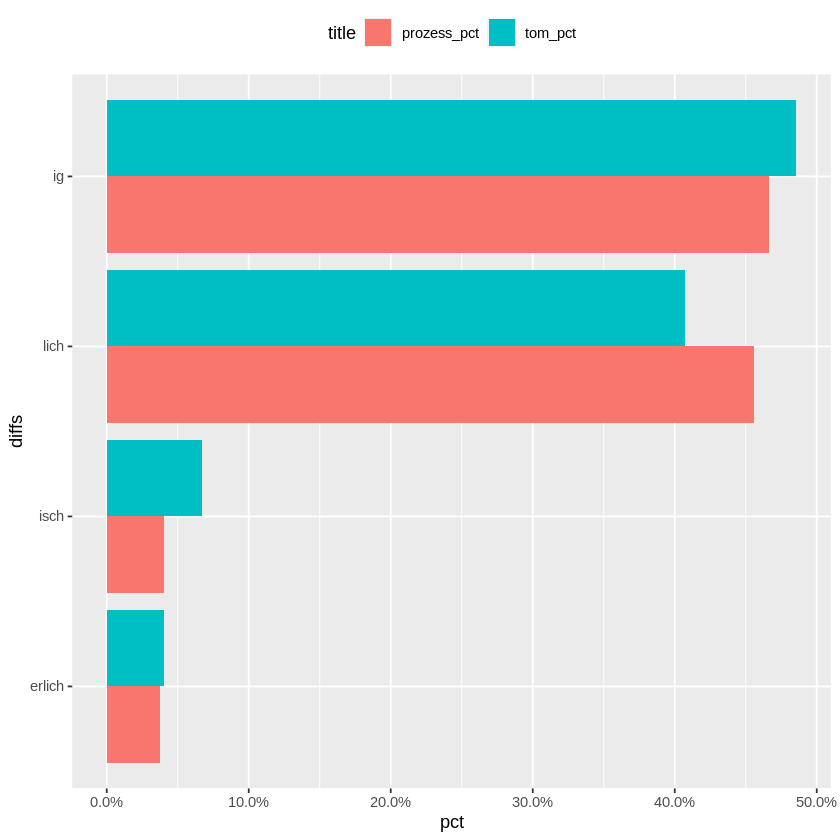

In [ ]:
library(scales)

adj_tab %>% 
  pivot_longer(prozess_pct:tom_pct, names_to = "title", values_to = "pct") %>% 
  mutate(diffs = fct_reorder(diffs, pct)) %>% 
  ggplot(aes(pct, diffs, fill = title)) +
  geom_col(position = "dodge") +
  scale_x_continuous(labels = percent) +
  theme(legend.position = "top")


# Nicht verwendete Tabelle



In [ ]:
novels_full_words %>% 
  select(doc_id, lemma, stamm, diffs) %>%
  group_by(doc_id) %>% 
  filter(diffs != "") %>%
  add_count(doc_id, name = "total") %>% 
  add_count(diffs) %>% 
  mutate(pct = n/total) %>%
  pivot_wider(names_from = doc_id, values_from = n, names_repair = "unique") %>% 
  unnest(c(prozess, tom)) %>% 
  paged_table()
